5/29/19
Change accuracy graphs to look at cumulative number correct, ascending or descending. 
Ex: for np; x axis is still the np possible values,
y axis is percent correct, where count all correct in current np group and all np groups with np lower (if descending cumulative) or all np groups with np higher than current np (if ascending cumulative) 


4/25/19
Pandas on ccs and lima score report csv files
Main goal: combine the two csv files, with the rows (indices) being the ZMW hole numbers

Note: axis 1: horizontal; move across all columns
      axis 0: vertical; move across all rows
      
Recall: ccs parameter descriptions
RG Tag: read group id
np: number of passes
rq: predicted read quality
za: avg Z-score of all subreads successfully added


In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [159]:
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
plt.close('all')
#if using remote system: files located at: 
# bam_table.csv: /tier2/deweylab/scratch/ipsc_pacbio/demultiplexing/
#                 demultiplexed_full_bams/baseline/absolute_ccs/2_B01/bam_table.csv
#
#score_report_span_0: /tier2/deweylab/scratch/ipsc_pacbio/demultiplexing/
#     demultiplexed_full_bams/baseline/absolute_ccs/2_B01/lima_baseline/
#     ref_span_0/score_report_span_0
#
#
df_ccs = pd.read_csv('/Users/catherineanderson/Documents/Research_Spring_2019/bam_table.csv')
df_ccs = df_ccs.set_index('ZMW hole number')
#dropping RG Tag because it's just an id
df_ccs = df_ccs.drop('RG Tag', axis=1)


df_lima = pd.read_csv('/Users/catherineanderson/Documents/Research_Spring_2019/score_report_span_0.csv')
df_lima = df_lima.set_index('ZMW hole number')



#df_ccs



In [278]:
#df_lima[['IdxsCombined a', 'IdxsCombined b']]
#df_lima
df_lima.columns


Index(['IdxFirst', 'IdxCombined', 'IdxSecondCandidate', 'IdxFirstAlt',
       'IdxSecondAlt', 'ScoreFirst', 'ScoreCombined', 'ScoreSecondCandidate',
       'ScoreFirstAlt', 'ScoreSecondAlt', 'ScoreCombinedFirst',
       'ScoreCombinedSecond', 'ScoresFirstA', 'ScoresFirstB',
       'ScoresCombinedA', 'ScoresCombinedB', 'ScoresSecondCandidateA',
       'ScoresSecondCandidateB', 'ScoresFirstAltA', 'ScoresFirstAltB',
       'ScoresSecondAltA', 'ScoresSecondAltB', 'ReadLengths', 'IdxsCombinedA',
       'IdxsCombinedB', 'ClipsFirstA', 'ClipsFirstB', 'ClipsCombinedA',
       'ClipsCombinedB', 'ClipsSecondCandidateA', 'ClipsSecondCandidateB',
       'ClipsFirstAltA', 'ClipsFirstAltB', 'ClipsSecondAltA',
       'ClipsSecondAltB', 'ScoreLead', 'SignalIncrease', 'NumPasses',
       'NumAdapters', 'NumScoredAdapters', 'NumBarcodedRegions',
       'NumBarcodedRegionsPassed', 'PassedFilters', 'IdxFirstNamed',
       'IdxCombinedNamed', 'IdxSecondCandidateNamed', 'IdxFirstAltNamed',
       'IdxSecond

In [161]:
df_combo = pd.merge(df_ccs,df_lima, on="ZMW hole number")


In [162]:
#takes in a GroupBy's object
#returns the number of zmws correctly barcoded
def correct_count (gb):
    count_dict = {}
    for name, group in gb:
        count = 0
  #      print ("name:", name)
  #      print ("group:")
  #      print(group)
        for row_index, row_data in group.iterrows():
 #           print("row_index: ",row_index)
  #          print("row_data: ")
  #          print(row_data)
            first_id = row_data['IdxsCombinedA']
            second_id = row_data['IdxsCombinedB']
  #          print("first id:",first_id)
  #          print("second id:",second_id)
   #     print()
        
            if(first_id == 3):
                if(second_id == 0):
                    count += 1
            elif(first_id == 0):
                if(second_id == 3):
                    count += 1
        count_dict[name] = count
 #   print("count_dict: ",count_dict)
    return count_dict;
        
        


In [163]:
#takes in a GroupBy object 
#returns the (decimal) percent correctly barcoded
def percent_correct(gb):
    correct_count_dict = correct_count(gb)
    group_sizes_dict = gb.size()
    percent_correct_dict = {}
    for name, group in gb:
        percent_correct_dict[name] = correct_count_dict[name]/group_sizes_dict[name]
    return percent_correct_dict
    

In [164]:
#calculates cumulative count correct
#given groupby object "gb" and an "ascend" value 
#    (true if want cumulative of value plus all higher ie want to find min, 
#     false if want cumulative of value plus all lower ie want to find max) 
def cumulative_count_correct(ascend,gb):
    count = 0
    count_dict = {}
    if ascend == False: #correct count is count of current plus count of all lower
        for name, group in gb:
            #print ("np (name):", name)
        
            for row_index, row_data in group.iterrows():
                first_id = row_data['IdxsCombinedA']
                second_id = row_data['IdxsCombinedB']
   #             print("first_id:",first_id)
    #            print("second_id:",second_id)
                if(first_id == 3):
                    if(second_id == 0):
                        count += 1
                elif(first_id == 0):
                    if(second_id == 3):
                        count += 1
            count_dict[name] = count
    else: #correct count is count of current plus count of all greater
        noncumulative_count_dict = correct_count(gb)
        sorted_dict_keys = sorted(noncumulative_count_dict.keys(),reverse=True)
        count_dict[sorted_dict_keys[0]] = noncumulative_count_dict[sorted_dict_keys[0]]
        #print(sorted_dict_keys)
        for num in np.arange(1,len(sorted_dict_keys)):
            count_dict[sorted_dict_keys[num]] = count_dict[sorted_dict_keys[num-1]] + noncumulative_count_dict[sorted_dict_keys[num]]
                
        #print("non_cumulative_count_dict:")
        #print(noncumulative_count_dict)
        #print("cumulative_count_dict")
        #print(count_dict)
        
    return count_dict
        

In [165]:
#calculates cumulative percent correct
#given groupby object "gb" and an "ascend" value 
#    (true if want cumulative of value plus all higher ie want to find min, 
#     false if want cumulative of value plus all lower ie want to find max) 
def cumulative_percent_correct(ascend,gb):
    correct_count_dict = cumulative_count_correct(ascend,gb)
    #print("correct_count_dict",correct_count_dict)
    noncumulative_group_sizes_dict = gb.size()
    cumulative_group_sizes_dict = {}
    percent_correct_dict = {}
    sorted_sizes = sorted(noncumulative_group_sizes_dict.keys(),reverse = ascend)
    cumulative_group_sizes_dict[sorted_sizes[0]] = noncumulative_group_sizes_dict[sorted_sizes[0]]
    #print("unsorted noncumulative sizes",noncumulative_group_sizes_dict)
    #print("sorted sizes",sorted_sizes)
    for num in np.arange(1,len(sorted_sizes)):
        cumulative_group_sizes_dict[sorted_sizes[num]] = noncumulative_group_sizes_dict[sorted_sizes[num]] + cumulative_group_sizes_dict[sorted_sizes[num-1]]
            
    #print("cumulative size dict:",cumulative_group_sizes_dict)
        
    for name,group in gb:
        percent_correct_dict[name] = correct_count_dict[name]/cumulative_group_sizes_dict[name]
    #print("percent_correct_dict",percent_correct_dict)
        
    return percent_correct_dict

Let's do CCS first. Parameters to consider: np (number of passes), rq (predicted read quality), za (avg z-score of zmw's successfully added subreads)

# NP

In [166]:
#need to separate out df_combo based on np; 
#if they have same np, they stay in same mini-dataframe
#want to find min np for the --minPasses ccs filter; want ascending cumulative; ascend = True
np_cumulative_percent_correct_dict = cumulative_percent_correct(True, df_combo.groupby('np'))


In [167]:
np_df = pd.DataFrame.from_dict(np_cumulative_percent_correct_dict, 'index',columns = ['Fraction correct'])

In [195]:
#np_df

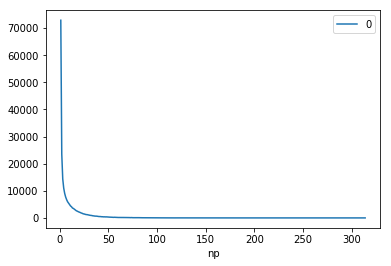

In [174]:
#look at distribution of np values
np_zmw_count =df_combo.groupby('np').size()
np_zmw_df = pd.DataFrame.from_dict(np_zmw_count)
np_zmw_df.plot()

It looks like nearly all ZMWs are below np=50

<Figure size 432x288 with 0 Axes>

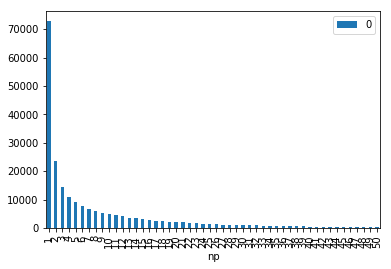

In [175]:
#zoom in on np=0
plt.figure();
np_ax = np_zmw_df.loc[0:50].plot(kind='bar')

(0, 10000)

<Figure size 432x288 with 0 Axes>

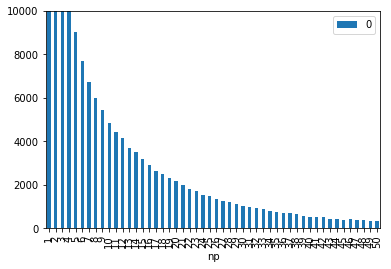

In [176]:
#zoom in on y axis too
plt.figure();
np_ax = np_zmw_df.loc[0:50].plot(kind='bar')
np_ax.set_ylim(0,10000)

Text(0,0.5,'(Ascending Cumulative) Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

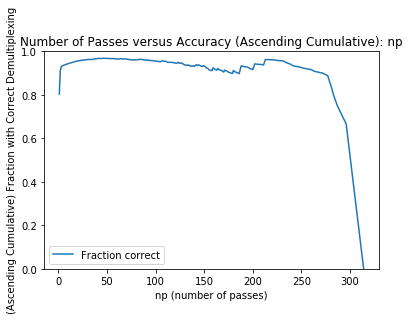

In [177]:
#now try a line plot
plt.figure();
np_ax2 = np_df.plot(title='Number of Passes versus Accuracy (Ascending Cumulative): np', use_index = True)
np_ax2.set_xlabel('np (number of passes)')
np_ax2.set_ylim(0, 1)
np_ax2.set_ylabel('(Ascending Cumulative) Fraction with Correct Demultiplexing')

Text(0,0.5,'(Ascending Cumulative) Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

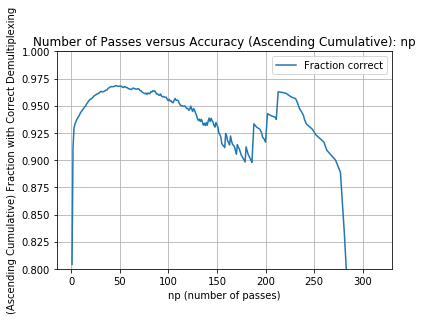

In [178]:
#zoom in on accuracy of 0.8 to 1.0
plt.figure();
np_ax2 = np_df.plot(grid = True,title='Number of Passes versus Accuracy (Ascending Cumulative): np', use_index = True)
np_ax2.set_xlabel('np (number of passes)')
np_ax2.set_ylim(0.8, 1)
np_ax2.set_ylabel('(Ascending Cumulative) Fraction with Correct Demultiplexing')

Text(0,0.5,'(Ascending Cumulative) Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

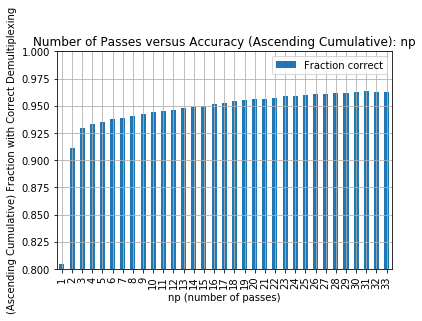

In [193]:
#zoom in on np=0
plt.figure();
np_ax2 = np_df.loc[0:33].plot(kind = 'bar',grid = True,title='Number of Passes versus Accuracy (Ascending Cumulative): np', use_index = True)
np_ax2.set_xlabel('np (number of passes)')
np_ax2.set_ylim(0.8, 1)
np_ax2.set_ylabel('(Ascending Cumulative) Fraction with Correct Demultiplexing')

# NP Conclusion
For sure, we shouldn't go lower than np=2 if we want an accuracy >=.9

Could make the minPasses filter higher, but will lose more data

# RQ: Read Quality

First: check the distribution of ZMWs over read quality scores

In [17]:
rq_zmw_count =df_combo.groupby('rq').size()

In [18]:
rq_zmw_df = pd.DataFrame.from_dict(rq_zmw_count)

<Figure size 432x288 with 0 Axes>

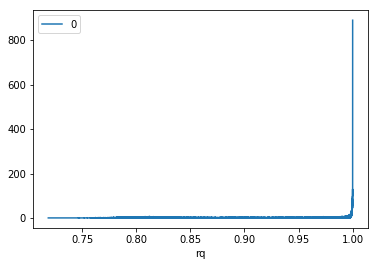

In [19]:
plt.figure()
ax = rq_zmw_df.plot()

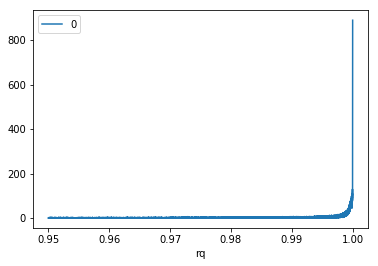

In [20]:
rq_zmw_df.loc[0.95:1].plot()

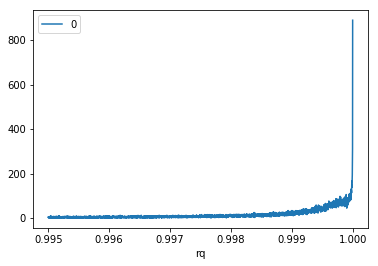

In [21]:
rq_zmw_df.loc[0.995:1].plot()

# It looks like almost all ZMWs are clustered between 0.999 and 1.00 (which is great!)

In [196]:
#Separate out based on read quality
#looking for value for --minReadScore, so want min; need ascending cumulative; ascend=True
rq_percent_correct_dict = cumulative_percent_correct(True,df_combo.groupby('rq'))
a = 1

In [197]:
rq_df = pd.DataFrame.from_dict(rq_percent_correct_dict, 'index',columns = ['Fraction correct'])

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

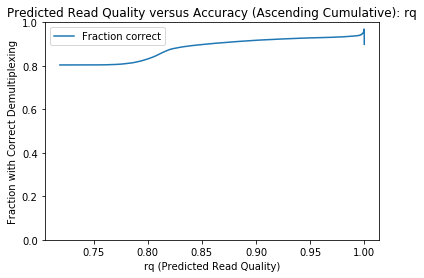

In [198]:
#now try a line graph
plt.figure();
rq_ax = rq_df.plot(title='Predicted Read Quality versus Accuracy (Ascending Cumulative): rq')
rq_ax.set_xlabel('rq (Predicted Read Quality)')
rq_ax.set_ylim(0, 1)
rq_ax.set_ylabel('Fraction with Correct Demultiplexing')

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

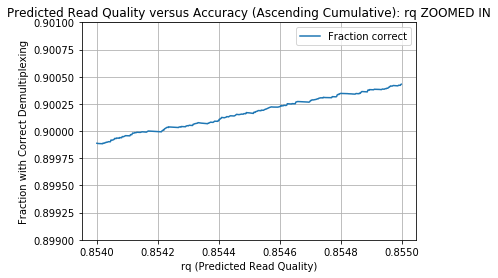

In [221]:
#Zoom in on area where accuracy is lower
plt.figure();
rq_ax = rq_df.loc[0.8540:0.8550].plot(grid=True,title='Predicted Read Quality versus Accuracy (Ascending Cumulative): rq ZOOMED IN')
rq_ax.set_xlabel('rq (Predicted Read Quality)')
rq_ax.set_ylim(0.899, 0.901)
rq_ax.set_ylabel('Fraction with Correct Demultiplexing')

For an accuracy >= 0.90, rq must be > 0.8542

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

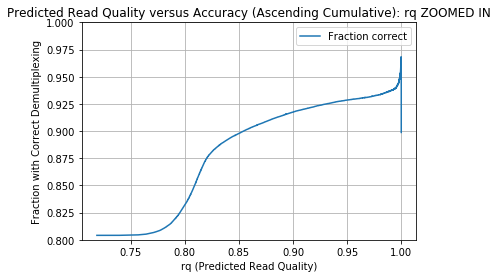

In [224]:
#Zoom in on area where accuracy is lower
plt.figure();
rq_ax = rq_df.plot( grid=True,title='Predicted Read Quality versus Accuracy (Ascending Cumulative): rq ZOOMED IN')
rq_ax.set_xlabel('rq (Predicted Read Quality)')
rq_ax.set_ylim(0.8, 1)
rq_ax.set_ylabel('Fraction with Correct Demultiplexing')

# RQ Conclusions
For an accuracy >= 0.90, rq must be > 0.8542

But could make minReadQuality value higher (gaining accuracy) without losing much data

# ZA 
(avg z-score of successfully added subreads)

First: distribution of zmws

In [29]:
#df_combo.sort_values(by='za')['za']
#za range: -43 to 43

In [226]:
za_zmw_count =df_combo.groupby('za').size()
za_zmw_df = pd.DataFrame.from_dict(za_zmw_count)

<Figure size 432x288 with 0 Axes>

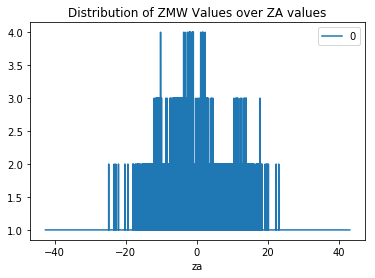

In [227]:
plt.figure()
ax = za_zmw_df.plot(title = 'Distribution of ZMW Values over ZA values')

In [228]:
#separate based on za
#want min; so want ascending cumulative; ascend=True
za_percent_correct_dict = cumulative_percent_correct(True,df_combo.groupby('za'))

In [229]:
za_df = pd.DataFrame.from_dict(za_percent_correct_dict, 'index',columns = ['Fraction correct'])

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

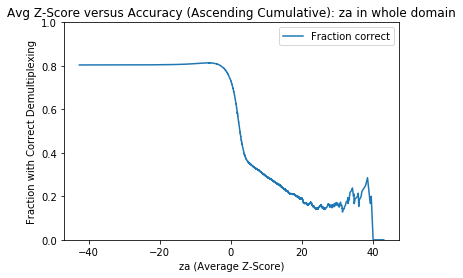

In [230]:
#look at accuracy: full view
plt.figure();
za_ax = za_df.plot(title='Avg Z-Score versus Accuracy (Ascending Cumulative): za in whole domain')
za_ax.set_xlabel('za (Average Z-Score)')
za_ax.set_ylim(0, 1)
#za_ax.set_xlim(-30,30)
za_ax.set_ylabel('Fraction with Correct Demultiplexing')

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

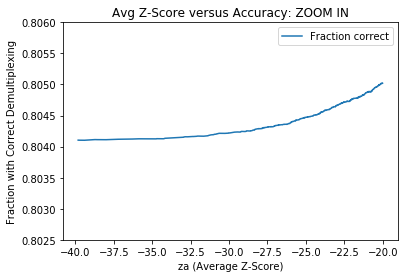

In [234]:
#zoom in
plt.figure();
za_ax = za_df.loc[-40:-20].plot(title='Avg Z-Score versus Accuracy: ZOOM IN')
za_ax.set_xlabel('za (Average Z-Score)')
za_ax.set_ylim(0.8025, 0.806)
za_ax.set_ylabel('Fraction with Correct Demultiplexing')

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

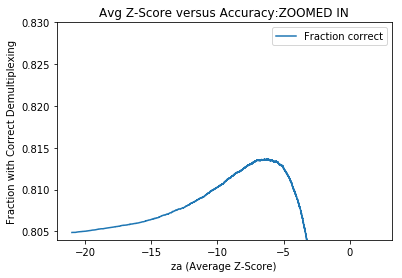

In [239]:
#zoom in
plt.figure();
za_ax = za_df.loc[-21:2].plot(title='Avg Z-Score versus Accuracy:ZOOMED IN')
za_ax.set_xlabel('za (Average Z-Score)')
za_ax.set_ylim(0.804, 0.83)
za_ax.set_ylabel('Fraction with Correct Demultiplexing')

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

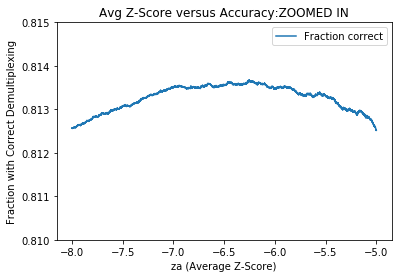

In [246]:
#zoom in
plt.figure();
za_ax = za_df.loc[-8:-5].plot(title='Avg Z-Score versus Accuracy:ZOOMED IN')
za_ax.set_xlabel('za (Average Z-Score)')
za_ax.set_ylim(0.81, 0.815)
za_ax.set_ylabel('Fraction with Correct Demultiplexing')

# ZA Conclusion:
Somewhere around a min za of -6.25 we get our best cumulative accuracy at about 0.8135
However even with the min za at its lowest, around -40, we get an accuracy of ~ 0.804

# LIMA PARAMETERS

# NumPasses
(number of full passes; read flanked by adapter on each side)

In [280]:
numPass_zmw_count =df_combo.groupby('NumPasses').size()
numPass_zmw_df = pd.DataFrame.from_dict(numPass_zmw_count)

In [282]:
df_combo.sort_values(by='NumPasses')['NumPasses']
#Range: 0 to 1 for some reason. Why?

ZMW hole number
26673793    0
31916739    0
38994447    0
69796385    0
50135447    0
17105524    0
48235036    0
25101257    0
13107585    0
16580811    0
19661072    0
14614711    0
45089453    0
47186515    0
6553787     0
19005984    0
41812168    0
24248585    0
14484392    0
34537820    0
50921967    0
5833405     0
40043088    0
53477936    0
37618252    0
52363927    0
47645170    0
15991429    0
12190349    0
50332433    0
           ..
22151760    1
22085760    1
22151692    1
22151687    1
22151601    1
22151602    1
22151618    1
22151623    1
22151625    1
22151626    1
22151628    1
22151631    1
22151633    1
22151634    1
22151635    1
22151690    1
22151636    1
22151646    1
22151650    1
22151653    1
22151654    1
22151663    1
22151664    1
22151670    1
22151671    1
22151673    1
22151676    1
22151686    1
22151645    1
74908659    1
Name: NumPasses, Length: 225537, dtype: int64

<Figure size 432x288 with 0 Axes>

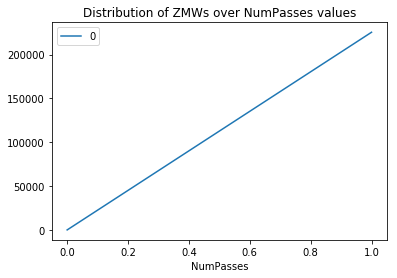

In [281]:
plt.figure()
ax = numPass_zmw_df.plot(title = 'Distribution of ZMWs over NumPasses values')

# ScoreLead
(how close first barcode call is to second. if filter too low get false positives)

In [247]:
score_lead_zmw_count =df_combo.groupby('ScoreLead').size()
score_lead_zmw_df = pd.DataFrame.from_dict(score_lead_zmw_count)

<Figure size 432x288 with 0 Axes>

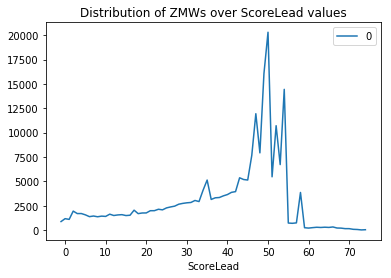

In [249]:
plt.figure()
ax = score_lead_zmw_df.plot(title = 'Distribution of ZMWs over ScoreLead values')

Big drop off somewhere between 50 and 70. 

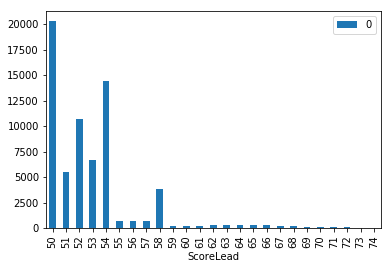

In [41]:
score_lead_zmw_df.loc[50:].plot(kind='bar')

Looks like nearly all zmws lie at ScoreLead <=58. However, the larger the ScoreLead, the lower the chance of false positives. It would be nice to keep as many high ScoreLead zmws as possible.

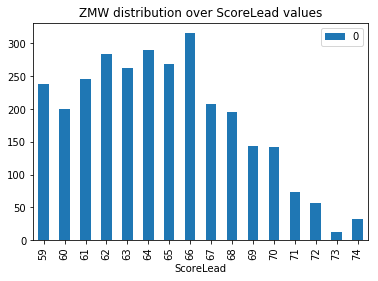

In [42]:
score_lead_zmw_df.loc[59:].plot(kind='bar', title='ZMW distribution over ScoreLead values')

Even the "dropoff" in the quantity of ZMWs in each bin still has a sizable amount, so we probably don't need to exclude ScoreLead values based strictly off of ZMW distribution. 

In [250]:
#want min; want ascending cumulative; ascend = true
score_lead_percent_correct_dict = cumulative_percent_correct(True,df_combo.groupby('ScoreLead'))

In [251]:
score_lead_df = pd.DataFrame.from_dict(score_lead_percent_correct_dict, 'index',columns = ['Fraction correct'])

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

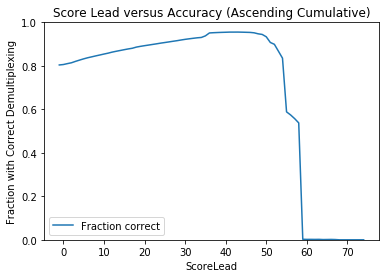

In [253]:
#look at accuracy: full view
plt.figure();
score_lead_ax = score_lead_df.plot(title='Score Lead versus Accuracy (Ascending Cumulative)')
score_lead_ax.set_xlabel('ScoreLead')
score_lead_ax.set_ylim(0, 1)
#za_ax.set_xlim(-30,30)
score_lead_ax.set_ylabel('Fraction with Correct Demultiplexing')

# Looking for minimum
Best accuracy minimum is somewhere in ScoreLead belonging to [30,55]

HOWEVER also want to retain as much data as possible, and lots of data below that range. 

In [46]:
#df_combo.sort_values(by='ScoreLead')['ScoreLead']
#Range: -1 to 74

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

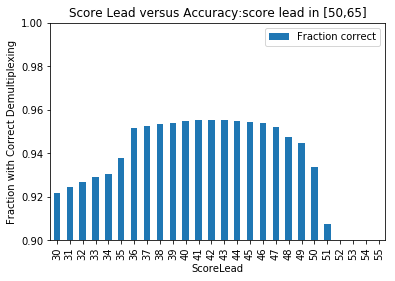

In [255]:
#zoom in to find most accurate min ScoreLead
plt.figure();
score_lead_ax = score_lead_df.loc[30:55].plot(kind = 'bar',title='Score Lead versus Accuracy: ZOOM IN')
score_lead_ax.set_xlabel('ScoreLead')
score_lead_ax.set_ylim(0.9, 1)
#za_ax.set_xlim(-30,30)
score_lead_ax.set_ylabel('Fraction with Correct Demultiplexing')

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

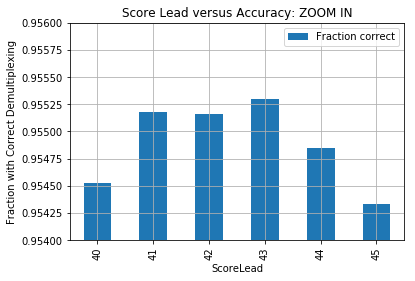

In [265]:
#zoom in to find most accurate min ScoreLead
plt.figure();
score_lead_ax = score_lead_df.loc[40:45].plot(grid = True,kind = 'bar',title='Score Lead versus Accuracy: ZOOM IN')
score_lead_ax.set_xlabel('ScoreLead')
score_lead_ax.set_ylim(0.954, 0.956)
#za_ax.set_xlim(-30,30)
score_lead_ax.set_ylabel('Fraction with Correct Demultiplexing')

MOST ACCURATE min score lead is 43 with accuracy > 0.95525


Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

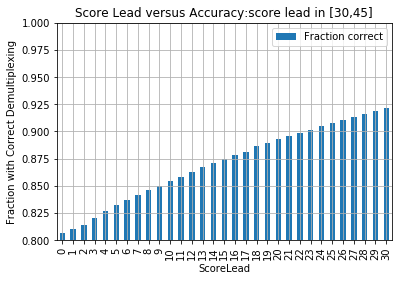

In [266]:
#zoom in to find lowest min score lead with accuracy >= 0.9
plt.figure();
score_lead_ax = score_lead_df.loc[0:30].plot(kind = 'bar', grid = True, title='Score Lead versus Accuracy:score lead in [30,45]')
score_lead_ax.set_xlabel('ScoreLead')
score_lead_ax.set_ylim(0.8, 1)
#za_ax.set_xlim(-30,30)
score_lead_ax.set_ylabel('Fraction with Correct Demultiplexing')

For accuracy >= .9, want min ScoreLead >=23

# ScoreLead Conclusion:
For accuracy >= 0.9, want min ScoreLead >= 23

For best accuracy of >0.95525, want min ScoreLead = 43

# PassedFilters
(1 if passed Lima filters, 0 if not)

In [49]:
passed_filters_zmw_count =df_combo.groupby('PassedFilters').size()
passed_filters_zmw_df = pd.DataFrame.from_dict(passed_filters_zmw_count)

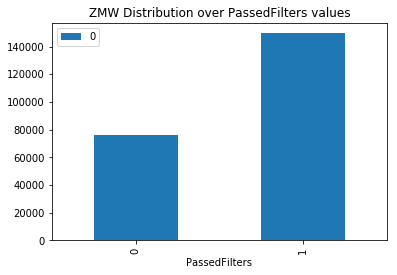

In [50]:
passed_filters_zmw_df.plot(kind = 'bar',title="ZMW Distribution over PassedFilters values")

In [51]:
passed_filters_percent_correct_dict = percent_correct(df_combo.groupby('PassedFilters'))

In [52]:
passed_filters_df = pd.DataFrame.from_dict(passed_filters_percent_correct_dict,
                                           'index',columns = ['Fraction correct'])

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

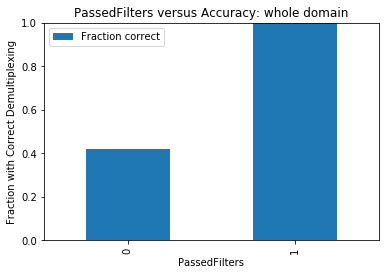

In [53]:
#look at accuracy: full view
plt.figure();
ax = passed_filters_df.plot(kind = 'bar',title='PassedFilters versus Accuracy: whole domain')
ax.set_xlabel('PassedFilters')
ax.set_ylim(0, 1)
#za_ax.set_xlim(-30,30)
ax.set_ylabel('Fraction with Correct Demultiplexing')

# PassedFilters Conclusion:
Only keep those that have PassedFilters=1 (ie those that pass Lima Filters)

# NumBarcodedRegions
(number of barcode regions identified in read)

In [54]:
numBarcoded_zmw_count =df_combo.groupby('NumBarcodedRegions').size()
numBarcoded_zmw_df = pd.DataFrame.from_dict(numBarcoded_zmw_count)

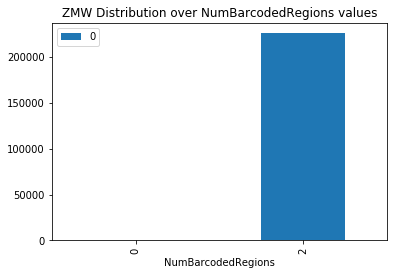

In [55]:
numBarcoded_zmw_df.plot(kind = 'bar',title="ZMW Distribution over NumBarcodedRegions values")

In [56]:
numBarcoded_zmw_count

NumBarcodedRegions
0        31
2    225506
dtype: int64

Most reads have two barcoded regions (good; 5' and 3'). Some have zero, which we obviously don't want. 

In [57]:
numBarcoded_percent_correct_dict = percent_correct(df_combo.groupby('NumBarcodedRegions'))

In [58]:
numBarcoded_df = pd.DataFrame.from_dict(numBarcoded_percent_correct_dict,
                                           'index',columns = ['Fraction correct'])

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

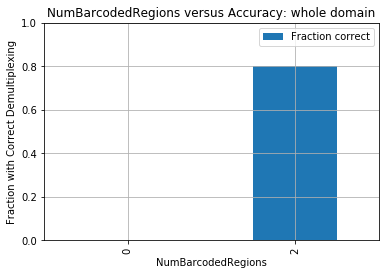

In [59]:
#look at accuracy: full view
plt.figure();
ax = numBarcoded_df.plot(kind = 'bar',grid = True,title='NumBarcodedRegions versus Accuracy: whole domain')
ax.set_xlabel('NumBarcodedRegions')
ax.set_ylim(0, 1)
#za_ax.set_xlim(-30,30)
ax.set_ylabel('Fraction with Correct Demultiplexing')

# NumBarcodedRegions Conclusions:
Want this equal to 2.

# NumBarcodedRegionsPassed
(of barcode regions identified in read, how many passed relevant filters? Intuition would say we want 2 to pass)

In [60]:
barPass_zmw_count =df_combo.groupby('NumBarcodedRegionsPassed').size()
barPass_zmw_df = pd.DataFrame.from_dict(barPass_zmw_count)

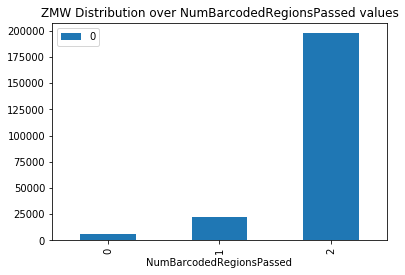

In [61]:
barPass_zmw_df.plot(kind = 'bar',title="ZMW Distribution over NumBarcodedRegionsPassed values")

In [62]:
barPass_percent_correct_dict = percent_correct(df_combo.groupby('NumBarcodedRegionsPassed'))

In [63]:
barPass_df = pd.DataFrame.from_dict(barPass_percent_correct_dict,
                                           'index',columns = ['Fraction correct'])

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

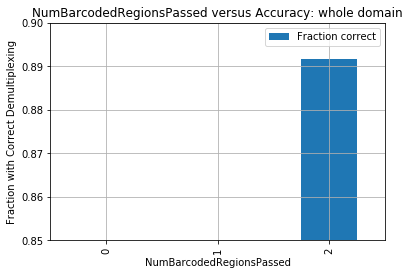

In [64]:
#look at accuracy: full view
plt.figure();
ax = barPass_df.plot(kind = 'bar',grid = True,title='NumBarcodedRegionsPassed versus Accuracy: whole domain')
ax.set_xlabel('NumBarcodedRegionsPassed')
ax.set_ylim(0.85, .9)
#za_ax.set_xlim(-30,30)
ax.set_ylabel('Fraction with Correct Demultiplexing')

In [65]:
barPass_df

,Fraction correct
0,0.072875
1,0.215190
2,0.891649


# NumBarcodedRegionsPassed Conclusion
want equal to 2

# SignalIncrease
(not sure. Reflection of degree of noise? Like the lower it is, the noisier the signal when sequencing?)

In [267]:
signal_zmw_count =df_combo.groupby('SignalIncrease').size()
signal_zmw_df = pd.DataFrame.from_dict(signal_zmw_count)

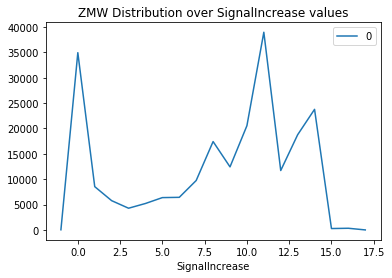

In [276]:
signal_zmw_df.plot(title="ZMW Distribution over SignalIncrease values")

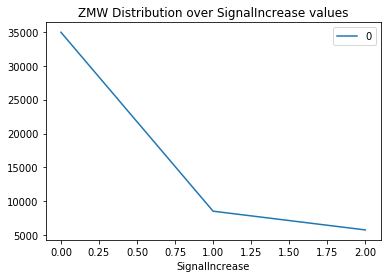

In [277]:
signal_zmw_df.loc[0:2].plot(title="ZMW Distribution over SignalIncrease values")

In [269]:
#want min; ascend = True
signal_percent_correct_dict = cumulative_percent_correct(True,df_combo.groupby('SignalIncrease'))

In [270]:
signal_df = pd.DataFrame.from_dict(signal_percent_correct_dict,
                                           'index',columns = ['Fraction correct'])

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

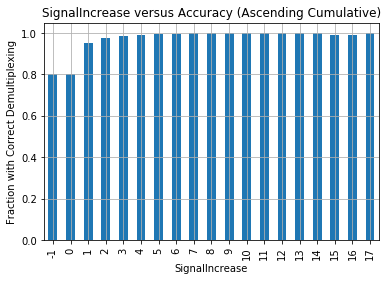

In [272]:
#look at accuracy: full view
plt.figure();
ax = signal_df.plot(legend=False,kind = 'bar',grid = True,title='SignalIncrease versus Accuracy (Ascending Cumulative)')
ax.set_xlabel('SignalIncrease')
#ax.set_ylim(0, 1)
#za_ax.set_xlim(-30,30)
ax.set_ylabel('Fraction with Correct Demultiplexing')

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

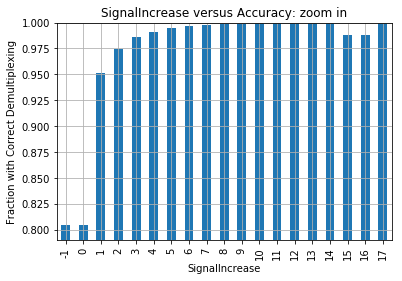

In [274]:
#look at accuracy: zoom in
plt.figure();
ax = signal_df.plot(legend=False,kind = 'bar',grid = True,title='SignalIncrease versus Accuracy: zoom in')
ax.set_xlabel('SignalIncrease')
ax.set_ylim(0.79, 1)
#za_ax.set_xlim(-30,30)
ax.set_ylabel('Fraction with Correct Demultiplexing')

# SignalIncrease Conclusion: 
For accuracy >= 0.95: SignalIncrease >= 1

BUT that takes away a huge amount of ZMWs. Could include all and still have accuracy > 0.8

Could easily get higher accuracy with higher min SignalIncrease value

# BarcodeScores
Average of ScoresCombineA and ScoresCombinedB
Expect linear; should be same as way I'm assessing accuracy

In [283]:
#First: need to add column to df_combo
barcode_scores = pd.Series(np.arange(0,225537),index=df_combo.index)

In [284]:
for index,value in barcode_scores.iteritems():
    avg = (df_combo.loc[index,'ScoresCombinedA'] + df_combo.loc[index,'ScoresCombinedB'])/2
    barcode_scores.loc[index] = avg
barcode_scores.head()


ZMW hole number
4194532    100.0
4194565    100.0
4194634    100.0
4194660     54.0
4194723     92.0
dtype: float64

In [285]:
df_combo['AvgScores'] = barcode_scores.values

In [286]:
barcode_zmw_count =df_combo.groupby('AvgScores').size()
barcode_zmw_df = pd.DataFrame.from_dict(barcode_zmw_count)

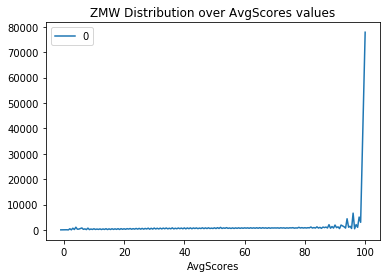

In [287]:
barcode_zmw_df.plot(title="ZMW Distribution over AvgScores values")

(0, 3000)

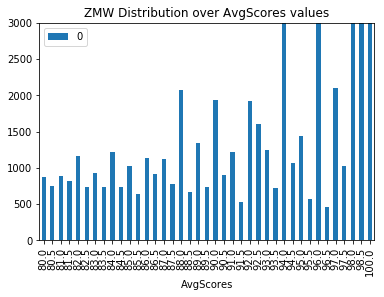

In [288]:
#zoom in: zoom on both axes
ax = barcode_zmw_df.loc[80:100].plot(kind = 'bar',title="ZMW Distribution over AvgScores values")
ax.set_ylim(0,3000) 

(0, 2000)

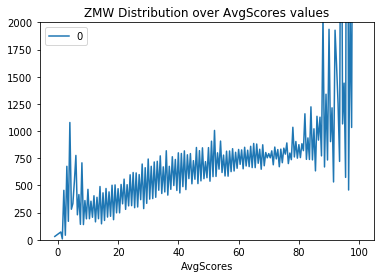

In [96]:
#zoom in: keep whole domain
ax = barcode_zmw_df.plot(title="ZMW Distribution over AvgScores values")
ax.set_ylim(0,2000) 

# Although definitely increase in amt of ZMWs as AvgScores value increase, hundreds of ZMWs even in the "low" portions of the graph

In [289]:
#want min; ascend = True
barcode_percent_correct_dict = cumulative_percent_correct(True,df_combo.groupby('AvgScores'))

In [290]:
barcode_df = pd.DataFrame.from_dict(barcode_percent_correct_dict,
                                           'index',columns = ['Fraction correct'])

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

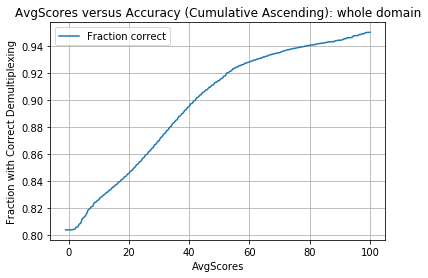

In [291]:
#look at accuracy: full view
plt.figure();
ax = barcode_df.plot(grid = True,title='AvgScores versus Accuracy (Cumulative Ascending): whole domain')
ax.set_xlabel('AvgScores')
#ax.set_ylim(0, 1)
#za_ax.set_xlim(-30,30)
ax.set_ylabel('Fraction with Correct Demultiplexing')

It appears that the lower our minimum z-score goes, the lower our accuracy becomes. Makes sense. Not quite linear, but close. 

42: Fraction correct    0.89997
Name: 42.0, dtype: float64
42.5: Fraction correct    0.90181
Name: 42.5, dtype: float64


<Figure size 432x288 with 0 Axes>

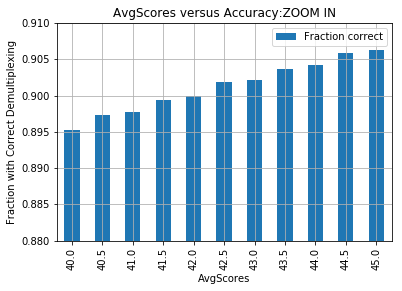

In [306]:
#zoom in
plt.figure();
ax = barcode_df.loc[40:45].plot(kind = 'bar',grid = True,title='AvgScores versus Accuracy:ZOOM IN')
ax.set_xlabel('AvgScores')
ax.set_ylim(0.88,0.91)
#za_ax.set_xlim(-30,30)
ax.set_ylabel('Fraction with Correct Demultiplexing')
print("42:",barcode_df.loc[42])
print("42.5:",barcode_df.loc[42.5])

Fraction correct    0.950231
Name: 100.0, dtype: float64


<Figure size 432x288 with 0 Axes>

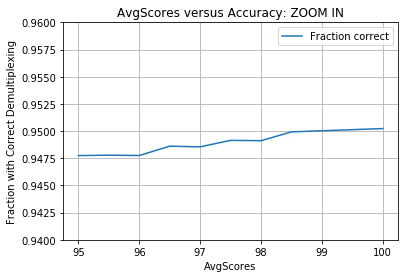

In [314]:
#look at "best" accuracy
#zoom in
plt.figure();
ax = barcode_df.loc[95:].plot(grid = True,title='AvgScores versus Accuracy: ZOOM IN')
ax.set_xlabel('AvgScores')
ax.set_ylim(0.94, 0.96)
#za_ax.set_xlim(-30,30)
ax.set_ylabel('Fraction with Correct Demultiplexing')
print(barcode_df.loc[100])

# BarcodeScores Conclusion:
accuracy >= 0.90: min AvgScores >= 42.5

max accuracy of 0.950231: min AvgScores =100

In [315]:
#df_combo